The structural organization and physical properties of collagen fibers are important for understanding tissue remodeling of the tissue microenvironment. This workflow demonstrates how collagen fibers can be extracted and analyzed from histological images. It includes:

- Extracting collagen fibers from the hematoxylin channel of H&E images.
- Converting collagen segmentations from raster to vector format for geometric analysis.
- Computing medial lines and smoothing collagen fiber geometries.
- Quantifying collagen fiber disorder using local orientation entropy.
- Calculating line metrics such as length, tortuosity, and average turning angle.

Let's start by loading some example data:

<Axes: >

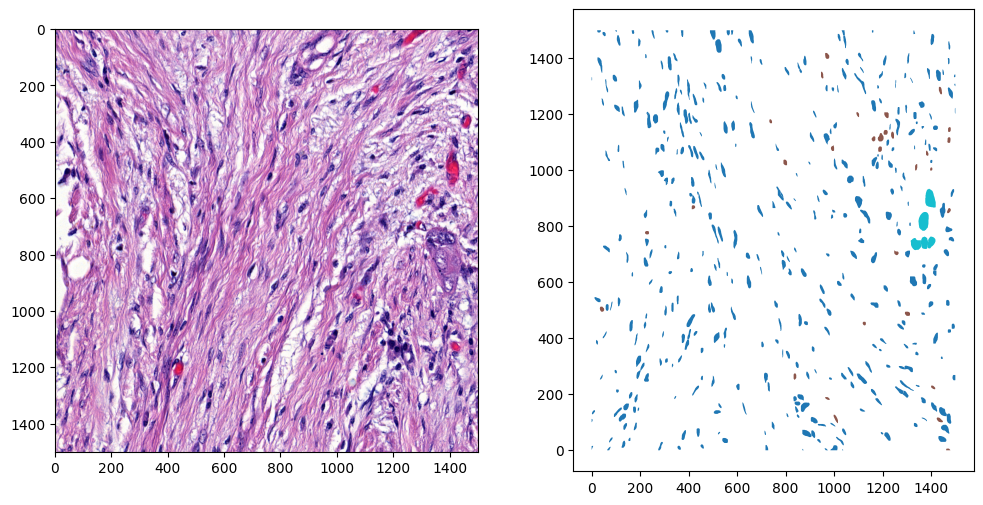

In [1]:
import matplotlib.pyplot as plt
from histolytics.data import hgsc_stroma_he, hgsc_stroma_nuclei

# Example data
nuc = hgsc_stroma_nuclei()
he = hgsc_stroma_he()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(he)
# note that the gdf has origin in bottom left, thus it is flipped
nuc.plot(ax=ax[1], figsize=(10, 10), column="class_name")

## Convert vector data to raster format

Like in the last tutorial, first, we will need to convert the vector data of nuclei to raster format, since working with rgb-image data, the nuclei masks need to be in raster-format for us to be able to point to the nuclear regions within the image. The conversion can be done using the `gdf2inst` and `gdf2sem` functions.

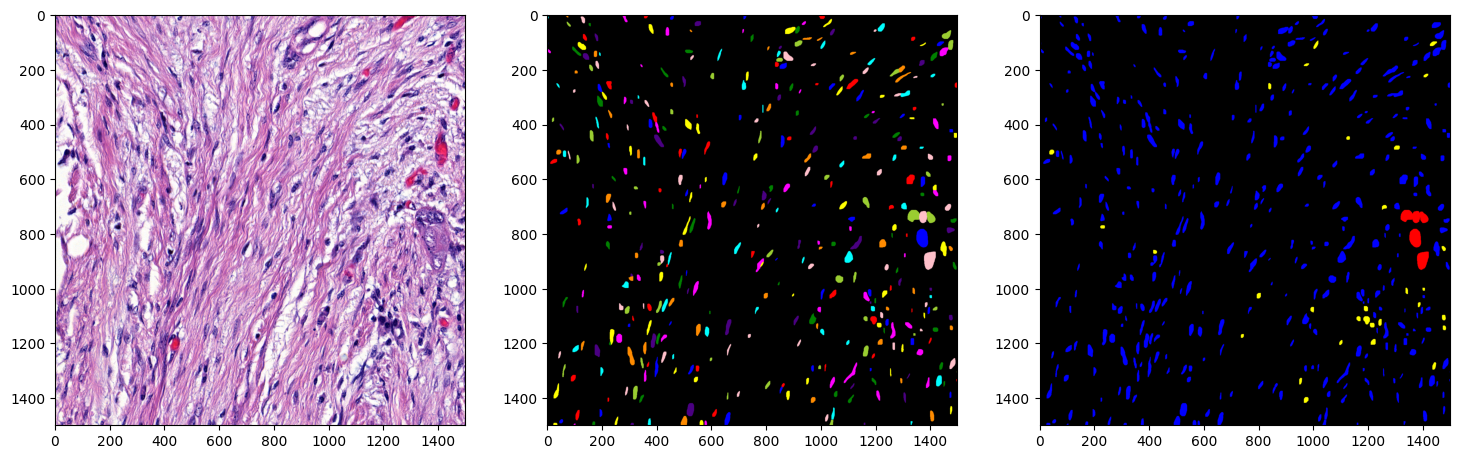

In [2]:
from histolytics.utils.raster import gdf2inst, gdf2sem
import matplotlib.pyplot as plt
from skimage.color import label2rgb


cls_dict = {
    "neoplastic": 1,
    "connective": 2,
    "inflammatory": 3,
}

# convert the nuclei gdf into raster mask
inst_mask = gdf2inst(nuc, width=he.shape[1], height=he.shape[0])
type_mask = gdf2sem(nuc, class_dict=cls_dict, width=he.shape[1], height=he.shape[0])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(he)
ax[1].imshow(label2rgb(inst_mask, bg_label=0, alpha=0.5))
ax[2].imshow(label2rgb(type_mask, bg_label=0, alpha=0.5))
plt.show()


## Extracting collagen fibers

Next, we will extract the collagen fibers from the rgb-image data. This can be done using the `extract_collagen_fibers` function, which takes the rgb-image data and the nuclei raster data as input. The function will return a label mask, containing the segmented collagen edges. Notice that we apply the extraction to the hematoxylin component of the input H&E image since this typically yields better results. 

The `extract_collagen_fibers` function takes several key parameters:

- **img**: The input image, typically the hematoxylin channel from H&E decomposition.
- **label**: A mask indicating the regions to be excluded when segmenting.
- **sigma**: Controls the amount of Gaussian smoothing applied before edge detection
- **rm_bg**: If set to `True`, background regions are removed before extracting collagen fibers. This typically, reudces some noise in the segmentation but can be too aggressive for some images, so you may want to experiment with this parameter depending on your data.

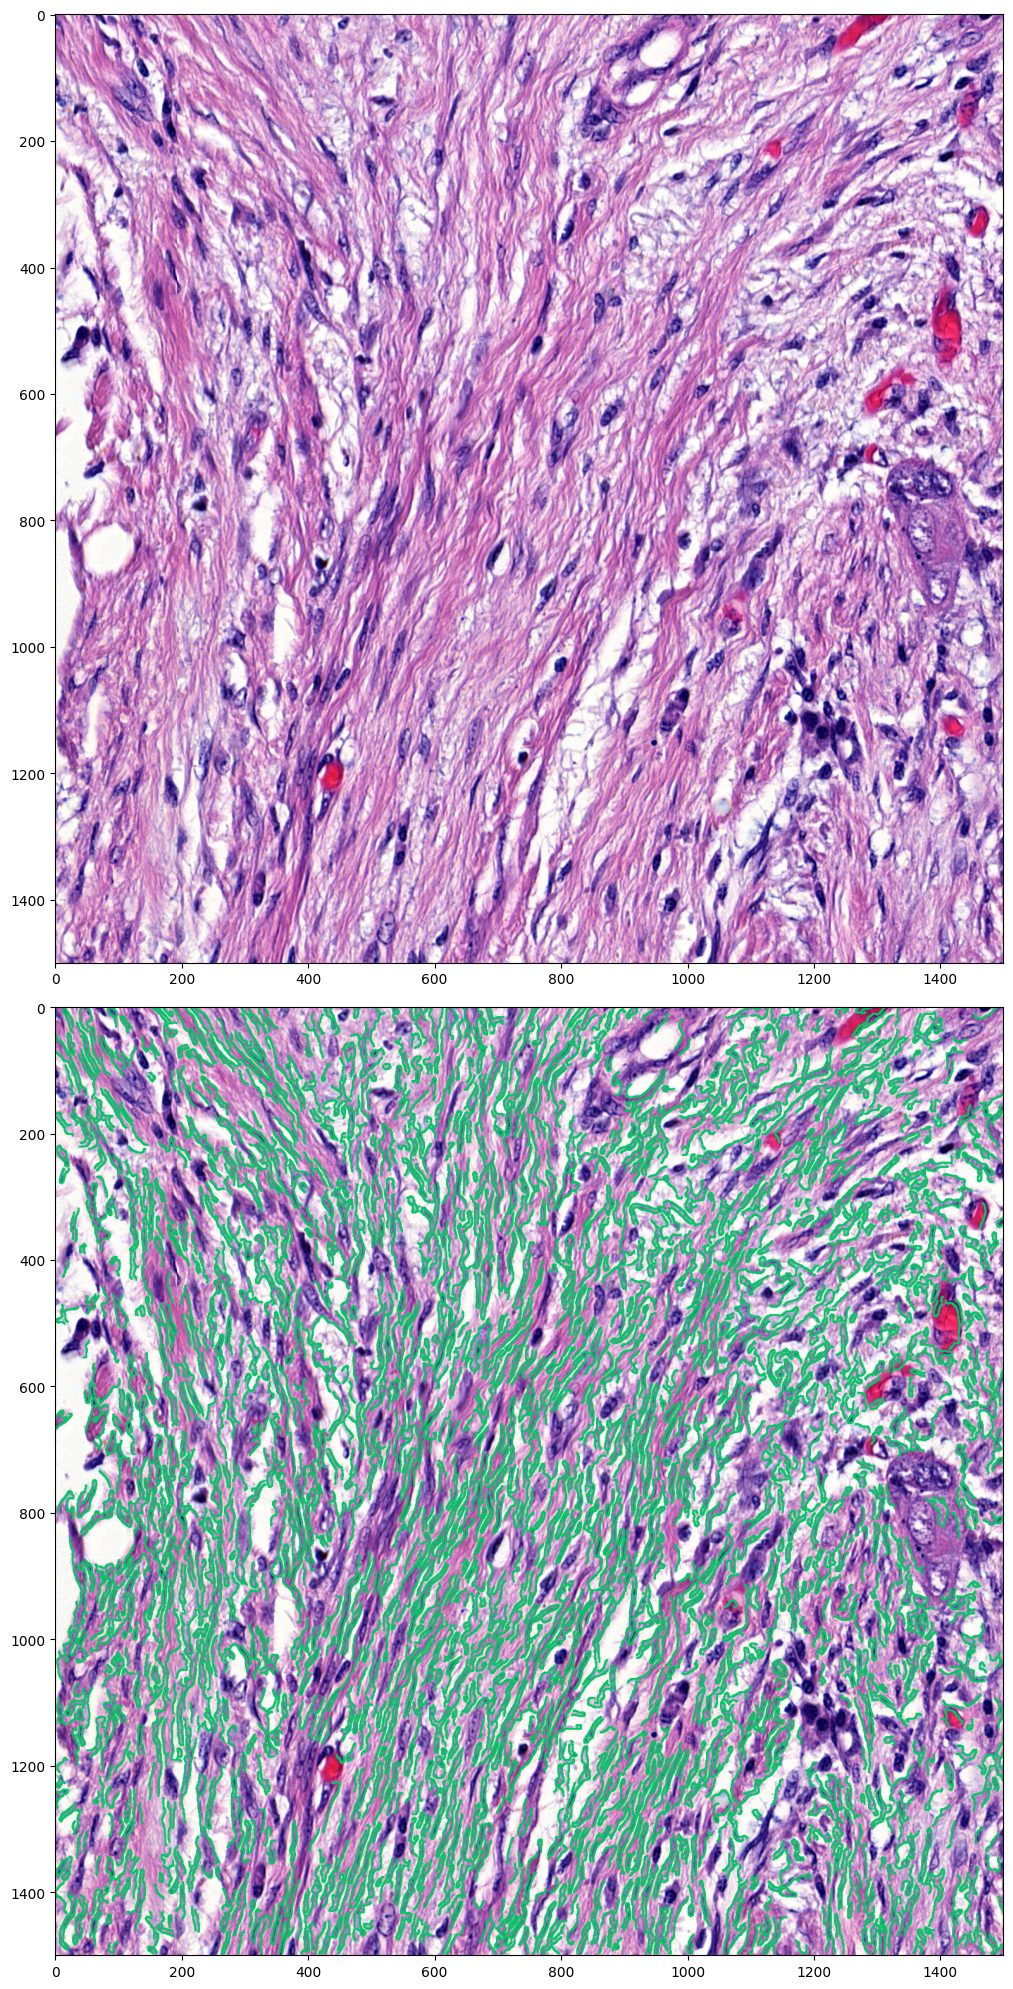

In [3]:
from histolytics.stroma_feats.utils import hed_decompose
from histolytics.stroma_feats.collagen import extract_collagen_fibers
from histolytics.utils.plot import draw_thing_contours

he_h, he_e, he_d = hed_decompose(he)

img = he.copy()
img_hematoxylin = he_h.copy()
img_eosin = he_e.copy()

edges = extract_collagen_fibers(
    img_hematoxylin, label=inst_mask, sigma=2.5, rm_bg=False
)
im_overlay = draw_thing_contours(edges, img, (edges > 0) + 1, thickness=2)

fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax = ax.flatten()
ax[0].imshow(img)
ax[1].imshow(im_overlay)
plt.tight_layout()

## Convert raster data to vector format

Next, we will need to convert the raster data of collagen fiber segmentations to back to vector format, so that we can use geopandas to manipulate the data. The conversion can be done using the `inst2gdf` function as follows:

In [4]:
import numpy as np
from skimage.morphology import dilation
from functools import partial
from skimage.measure import label

from histolytics.utils.raster import inst2gdf, gaussian_smooth

# convert the collagen raster mask to gdf
smooth_func = partial(gaussian_smooth, sigma=0.8)
cross = np.array([[1, 1], [1, 0]])
collagen_gdf = inst2gdf(
    dilation(label(edges), cross),
    xoff=0,
    yoff=0,
    min_size=5,
    smooth_func=smooth_func,
)
collagen_gdf.head(3)

id  class_name                                           geometry
0  42           1  POLYGON ((1268.977 0.273, 1268.749 0.772, 1268...
1   5           1  POLYGON ((169.977 0.273, 169.75 0.772, 169.273...
2  41           1  POLYGON ((1248.977 0.273, 1248.749 0.772, 1248...

Since the vectorization converts the collagen segmentations into polygon objects, we still want to convert these into line objects so that we can compute line-metrics on these objects. We will use the `medial_lines`-function, which is designed to find the medial lines of polyogns with Voronoi tessellation.

In [5]:
from histolytics.spatial_geom.medial_lines import medial_lines

collagen_gdf["geometry"] = collagen_gdf["geometry"].apply(
    lambda poly: medial_lines(poly)
)
collagen_gdf["geometry"] = collagen_gdf["geometry"].apply(
    smooth_func
)  # apply smoothing

collagen_gdf["class_name"] = "collagen"
collagen_gdf.head(3)

id class_name                                           geometry
0  42   collagen  MULTILINESTRING ((1269.684 1.339, 1269.674 1.3...
1   5   collagen  MULTILINESTRING ((170.171 1.558, 170.468 1.604...
2  41   collagen  MULTILINESTRING ((1238.794 16.581, 1238.676 16...

## Collagen fiber disorder

Collagen fiber disorder refers to the variability or randomness in the orientation of collagen fibers within tissue. In healthy or organized tissues, collagen fibers are typically aligned in parallel or regular patterns, while in pathological or remodeled tissues, fibers may become more disordered and randomly oriented. Quantifying collagen fiber disorder is important because it can provide insights into tissue remodeling. For example, increased collagen disorder has been associated with tumor invasion, fibrosis, and altered tissue stiffness. 

By computing the local neighborhood entropy of fiber orientations, we will assess the degree of structural organization or chaos in the collagen network. Here, we use the Shannon entropy to quantify the disorder of collagen fibers.

id class_name                                           geometry  uid  \
uid                                                                          
0    42   collagen  MULTILINESTRING ((1269.684 1.339, 1269.674 1.3...    0   
1     5   collagen  MULTILINESTRING ((170.171 1.558, 170.468 1.604...    1   
2    41   collagen  MULTILINESTRING ((1238.794 16.581, 1238.676 16...    2   

     major_axis_angle  major_axis_angle_shannon_index  
uid                                                    
0            0.282657                        1.113771  
1           32.646453                        0.482578  
2           34.895334                        1.214890

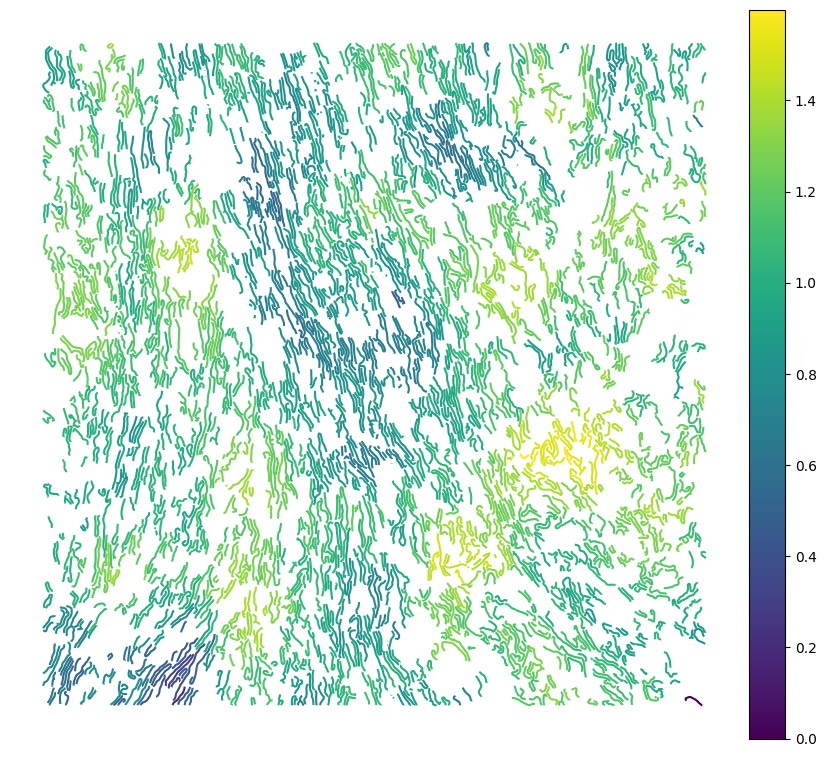

In [6]:
from histolytics.utils.gdf import gdf_apply, set_uid
from histolytics.spatial_graph.graph import fit_graph
from histolytics.spatial_agg.local_diversity import local_diversity
from histolytics.spatial_geom.shape_metrics import major_axis_angle
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# set unique identifiers for each geometry
collagen_gdf = set_uid(collagen_gdf, id_col="uid")

# compute the major axis angle for each geometry mrr (minimum rotated rectangle)
collagen_gdf["major_axis_angle"] = gdf_apply(
    collagen_gdf, major_axis_angle, columns=["geometry"]
)

# fit a graph to the geometries based on distance band
# and compute the shannon entropy of the major axis angles
wc, wc_gdf = fit_graph(collagen_gdf, "distband", threshold=100)
collagen_gdf = local_diversity(
    collagen_gdf,
    wc,
    val_cols=["major_axis_angle"],
    metrics=["shannon_index"],
    scheme="percentiles",  # bin the values into percentiles
    k=5,
)

collagen_gdf.plot(
    ax=ax, cax=cax, column="major_axis_angle_shannon_index", cmap="viridis", legend=True
)
ax.set_axis_off()
collagen_gdf.head(3)

In the above plot we can see that the regions with more chaotic collagen fiber orientation are colored in yellow, while the more organized regions are colored in blue. In the gdf, every collagen has a value for the the local disorder, which is the shannon entropy of the orientation distribution of the fibers in it's neighborhood

## Line metrics

Next, we will compute some extra line metrics for the collagen fibers. The `line_metrics` function can be used to compute various metrics such as length, tortuosity, and average_turning_angle of the collagen fibers. This function takes the vector data of collagen fibers as input and returns a DataFrame containing the computed metrics similar to the `shape_metric`-function we used in the nuclei morphology-tutorial.

- **Tortuosity**: Quantifies how much a fiber deviates from a straight line (ratio of actual length to the shortest distance between endpoints). Higher tortuosity suggests more winding or curved fibers.
- **Average Turning Angle**: Represents the average angle between consecutive segments along a fiber. Larger values indicate more frequent or sharper bends, reflecting fiber waviness or disorder.

id class_name                                           geometry  uid  \
uid                                                                          
0    42   collagen  MULTILINESTRING ((1269.684 1.339, 1269.674 1.3...    0   
1     5   collagen  MULTILINESTRING ((170.171 1.558, 170.468 1.604...    1   
2    41   collagen  MULTILINESTRING ((1238.794 16.581, 1238.676 16...    2   

     major_axis_angle  major_axis_angle_shannon_index  tortuosity  \
uid                                                                 
0            0.282657                        1.113771    1.679484   
1           32.646453                        0.482578    1.601931   
2           34.895334                        1.214890    2.228211   

     average_turning_angle     length  
uid                                    
0                 4.683425  44.455172  
1                 4.537734  30.485641  
2                 4.853571  43.677242

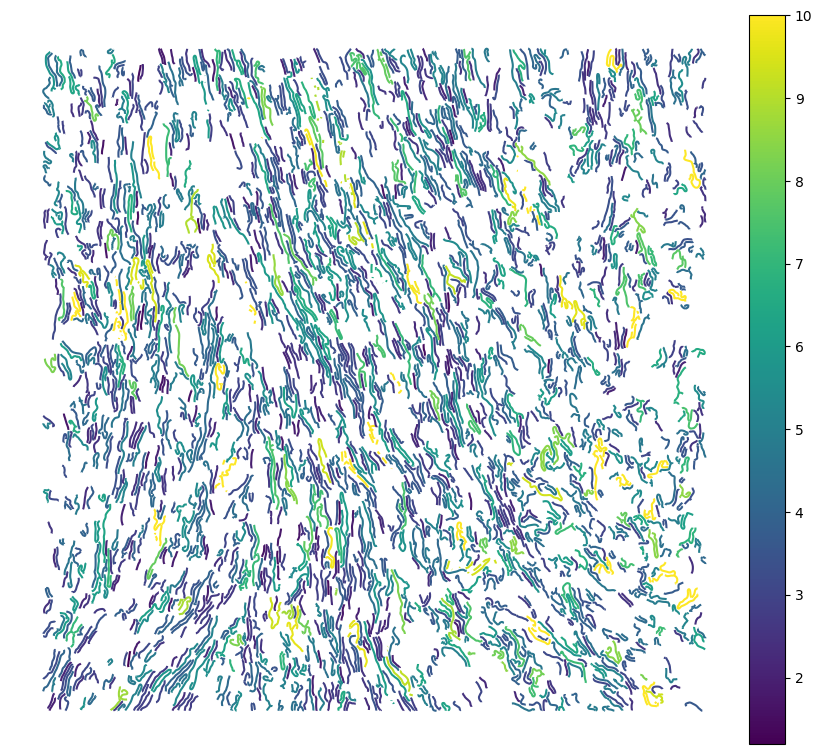

In [7]:
from histolytics.spatial_geom.line_metrics import line_metric

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# compute the line metrics for the collagen fibers
collagen_gdf = line_metric(
    collagen_gdf, metrics=["tortuosity", "average_turning_angle", "length"]
)

# Cap extreme values in 'average_turning_angle' to a reasonable maximum (e.g., 10)
max_turning_angle = 10
collagen_gdf["average_turning_angle"] = collagen_gdf["average_turning_angle"].clip(
    upper=max_turning_angle
)

collagen_gdf.plot(
    ax=ax, cax=cax, column="average_turning_angle", cmap="viridis", legend=True
)
ax.set_axis_off()
collagen_gdf.head(3)

Here we see that the collagen fibers with more etreme turns are colored in yellow, while the more straight fibers are colored in blue.

## Conclusion
In this workflow tutorial we have demonstrated how to extract and analyze collagen fibers from histological images. We have shown how to extract collagen fibers from the hematoxylin channel of H&E images, convert the segmentations from raster to vector format, compute medial lines and smooth the geometries, quantify collagen fiber disorder using local orientation entropy, and calculate line metrics such as length, tortuosity, and average turning angle. This type of analysis can be used to quantify collagen fiber organization and can provide insights into the tissue microenvironment and disease pathologies.